In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ase.build import nanotube
from ase.neighborlist import NeighborList
from qtpyt.base.greenfunction import GreenFunction
from qtpyt.base.leads import LeadSelfEnergy
from qtpyt.parallel.egrid import GridDesc
from qtpyt.tools import expand_coupling
from scipy.linalg import eigh
from ase.visualize import view


In [185]:
def create_nanotube(n=6, m=0, length=2, bond=1.42, pbc=True, direction="x"):

    """Create a carbon nanotube (CNT) using ASE.

    Args:
        n (int): Chiral index n.
        m (int): Chiral index m.
        length (int): Number of unit cells.
        bond (float): Carbon-carbon bond length.
        pbc (bool): Whether to apply periodic boundary conditions.
        direction (str): Direction of periodicity ('x', 'y', or 'z').

    Returns:
        ase.Atoms: ASE Atoms object representing the CNT.
    """
    atoms = nanotube(n=n, m=m, length=length, bond=bond,verbose=False)
    atoms.rotate('z', 'x', rotate_cell=True, center='COP')
    if pbc:
        if direction == "x":
            atoms.set_pbc((1, 0, 0))
        elif direction == "y":
            atoms.set_pbc((0, 1, 0))
        elif direction == "z":
            atoms.set_pbc((0, 0, 1))
        else:
            raise ValueError("Invalid direction. Use 'x', 'y', or 'z'.")
    return atoms

def build_real_space_lead_hamiltonian(atoms, bond=1.42, beta=0.0, t0=-2.7, neighbor_cutoff=1.43, atol=0.1):

    """Build the intra-cell (H0) and inter-cell (T) Hamiltonians for a CNT lead.

    Args:
        atoms (ase.Atoms): CNT structure with two unit cells.
        bond (float): Ideal bond length (in angstrom).
        beta (float): Exponential decay parameter for hopping.
        t0 (float): Nearest-neighbor hopping at ideal bond length (in eV).
        neighbor_cutoff (float): Distance threshold to consider neighbors.
        atol (float): Absolute tolerance in bond length matching.

    Returns:
        Tuple[np.ndarray, np.ndarray]: H0 and T matrices (both shape (N, N)).
    """
    N_total = len(atoms)
    N_unit = N_total // 2  # atoms in one unit cell

    positions = atoms.get_positions()
    cell = atoms.get_cell()

    # Neighbor list
    cutoffs = [neighbor_cutoff] * N_total
    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(atoms)

    # Initialize Hamiltonians
    H0 = np.zeros((N_unit, N_unit), dtype=float)
    T = np.zeros((N_unit, N_unit), dtype=float)

    for i in range(N_total):
        for j, offset in zip(*nl.get_neighbors(i)):
            if j <= i:
                continue
            ri = positions[i]
            rj = positions[j] + np.dot(offset, cell)
            dist = np.linalg.norm(ri - rj)
            if np.abs(dist - bond) > atol:
                continue  # skip non-neighbors
            hopping = t0 * np.exp(-beta * (dist / bond - 1))

            # Intra-cell bond
            if i < N_unit and j < N_unit:
                H0[i, j] = hopping
                H0[j, i] = hopping

            # Inter-cell bond
            elif i < N_unit and j >= N_unit:
                T[i, j - N_unit] = hopping

    return H0, T


def build_device_structure(n=6, m=0, N_L=3, N_M=4, N_R=3, bond=1.42, direction='x', tag_regions=True):
    """
    Build a CNT device using ASE nanotube with clear region tagging.

    Args:
        n, m: Chiral indices.
        N_L, N_M, N_R: Unit cells in left, middle, right.
        bond: C–C bond length.
        direction: Axis of tube ('x', 'y', or 'z').
        tag_regions: Whether to tag atoms by region (L=1, M=2, R=3).

    Returns:
        ase.Atoms with 'region' tags if enabled.
    """
    total_cells = N_L + N_M + N_R
    atoms = nanotube(n=n, m=m, length=total_cells, bond=bond, verbose=False)

    # Rotate so tube lies along 'direction'
    if direction == 'x':
        atoms.rotate('z', 'x', rotate_cell=True, center='COP')
        axis = 0
    elif direction == 'y':
        atoms.rotate('z', 'y', rotate_cell=True, center='COP')
        axis = 1
    elif direction == 'z':
        axis = 2
    else:
        raise ValueError("Direction must be 'x', 'y', or 'z'")

    # Determine boundaries
    positions = atoms.get_positions()
    coord = positions[:, axis]
    x_min, x_max = coord.min(), coord.max()
    total_len = x_max - x_min
    uc_len = total_len / total_cells

    # Region boundaries
    x_L = x_min + N_L * uc_len
    x_M = x_L + N_M * uc_len

    if tag_regions:
        regions = []
        for x in coord:
            if x < x_L:
                regions.append(1)  # Left
            elif x < x_M:
                regions.append(2)  # Middle
            else:
                regions.append(3)  # Right
        atoms.set_array('region', np.array(regions, dtype=int))

    atoms.set_pbc((1, 0, 0))  # set periodic only in tube direction
    return atoms


def get_nearest_neighbor_pairs(atoms, neighbor_cutoff=1.43, bond=1.42, atol=0.1):
    """
    Compute nearest-neighbor atom pairs using a distance cutoff and bond tolerance.

    Args:
        atoms (ase.Atoms): The atomic structure.
        neighbor_cutoff (float): Distance threshold for neighbors.
        bond (float): Ideal bond length.
        atol (float): Absolute tolerance for bond length deviation.

    Returns:
        List[Tuple[int, int, Tuple[int, int, int]]]: Valid neighbor pairs and cell offsets.
    """
    N = len(atoms)
    cutoffs = [neighbor_cutoff] * N
    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(atoms)

    positions = atoms.get_positions()
    cell = atoms.get_cell()

    pairs = set()
    for i in range(N):
        for j, offset in zip(*nl.get_neighbors(i)):
            if j > i:  # avoid double counting
                ri = positions[i]
                rj = positions[j] + np.dot(offset, cell)
                dist = np.linalg.norm(ri - rj)
                if np.abs(dist - bond) <= atol:
                    pairs.add((i, j, tuple(offset)))
    return list(pairs)


def apply_strain_to_region(atoms, N_L, N_M, N_R, strain=0.1):

    """Apply uniaxial strain to the middle region of a CNT device.

    Args:
        atoms (ase.Atoms): CNT device structure.
        N_L (int): Number of unit cells in the left lead.
        N_M (int): Number of unit cells in the middle region.
        N_R (int): Number of unit cells in the right lead.
        strain (float): Strain value (e.g., 0.1 = 10% stretch).

    Returns:
        None
    """

    positions = atoms.get_positions()
    unit_cell_len = np.max(positions[:, 0]) / (N_L + N_M + N_R)

    # Determine region bounds
    left_end = N_L * unit_cell_len
    right_start = (N_L + N_M) * unit_cell_len

    # Apply strain to atoms in the middle region
    strained_positions = positions.copy()
    for i, pos in enumerate(positions):
        if left_end <= pos[0] < right_start:
            strained_positions[i, 0] = left_end + (1 + strain) * (pos[0] - left_end)

    atoms.set_positions(strained_positions)


def build_real_space_device_hamiltonian(atoms, pairs, bond=1.42, beta=0.0, t0=-2.7, atol=0.1):

    """Construct real-space Hamiltonian for a CNT device using known neighbor pairs.

    Args:
        atoms (ase.Atoms): CNT device structure.
        pairs (List[Tuple[int, int, Tuple[int, int, int]]]): Precomputed nearest-neighbor pairs.
        bond (float): Ideal bond length.
        beta (float): Decay factor for hopping integral.
        t0 (float): Hopping at ideal bond length.
        atol (float): Absolute tolerance for bond length deviation.

    Returns:
        np.ndarray: Hamiltonian matrix (shape: N_atoms x N_atoms).
    """

    N_atoms = len(atoms)
    positions = atoms.get_positions()
    cell = atoms.get_cell()
    H = np.zeros((N_atoms, N_atoms), dtype=float)

    for i, j, offset in pairs:
        ri = positions[i]
        rj = positions[j] + np.dot(offset, cell)
        dist = np.linalg.norm(ri - rj)
        hopping = t0 * np.exp(-beta * (dist / bond - 1))
        H[i, j] = hopping
        H[j, i] = hopping

    return H


def plot_gamma_eigenvalues(self_energy, energies, label="Left Lead", log=True):
    """
    Plot eigenvalues of the broadening matrix Γ(E) for a given self-energy over a range of energies.

    Parameters:
        self_energy : LeadSelfEnergy object
        energies : 1D array of energies (in eV)
        label : str, label for the plot
        log : bool, whether to use log scale for y-axis
    """
    gamma_eigvals = []

    for E in energies:
        sigma = self_energy.retarded(E)
        gamma = 1j * (sigma - sigma.T.conj())
        eigs = np.linalg.eigvalsh(gamma)
        gamma_eigvals.append(eigs)

    gamma_eigvals = np.array(gamma_eigvals)  # shape: (len(energies), N)

    plt.figure(figsize=(8, 5))
    for n in range(gamma_eigvals.shape[1]):
        plt.plot(energies, gamma_eigvals[:, n], lw=0.8, alpha=0.6)

    plt.xlabel("Energy (eV)")
    plt.ylabel("Eigenvalues of Γ(E)")
    plt.title(f"Broadening Eigenvalues (Γ) for {label}")
    if log:
        plt.yscale('log')
        plt.ylim(bottom=1e-8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def compute_bands(H0, V, nk=1000):
    """Compute the band structure matrix for a 1D periodic system.

    Args:
        H0 (ndarray): Intra-cell Hamiltonian matrix (N, N).
        V (ndarray): Inter-cell hopping matrix (N, N).
        nk (int): Number of k-points in the Brillouin zone.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Tuple of (k-points, band energies of shape (nk, N)).
    """
    N = H0.shape[0]
    kpts = np.linspace(-np.pi, np.pi, nk)
    bands = np.empty((nk, N))

    for i, k in enumerate(kpts):
        H_k = H0 + V * np.exp(-1j * k) + V.conj().T * np.exp(1j * k)
        eigvals = eigh(H_k, eigvals_only=True)
        bands[i] = np.sort(eigvals.real)

    return kpts, bands


def compute_mode_count_from_bandstructure(H0, V, energies, nk=1000):
    """Count number of propagating modes at each energy based on band crossings.

    Args:
        H0 (ndarray): Intra-cell Hamiltonian.
        V (ndarray): Inter-cell hopping matrix.
        energies (ndarray): Energies (eV) at which to evaluate mode count.
        nk (int): Number of k-points for Brillouin zone sampling.

    Returns:
        ndarray: Number of propagating modes per energy.

    Notes:
        This function does not account for band degeneracy.
    """
    _, bands = compute_bands(H0, V, nk)
    mode_counts = []

    for E in energies:
        count = 0
        for band in bands.T:
            signs = np.sign(band - E)
            crossings = np.count_nonzero(np.diff(signs) != 0)
            count += crossings
        mode_counts.append(count)

    return np.array(mode_counts)


def plot_band_structure(H0, V, nk=200, energy_window=(-8, 8), title="CNT Band Structure"):
    """Plot band structure of a 1D periodic system using Bloch Hamiltonian.

    Args:
        H0 (ndarray): Intra-cell Hamiltonian (N, N).
        V (ndarray): Inter-cell hopping matrix (N, N).
        nk (int): Number of k-points in the Brillouin zone.
        energy_window (Tuple[float, float]): Energy range for the y-axis.
        title (str): Title of the plot.
    """
    kpts, bands = compute_bands(H0, V, nk)

    plt.figure(figsize=(8, 5))
    for band in bands.T:
        plt.plot(kpts / np.pi, band, lw=1)

    plt.xlabel("k / π")
    plt.ylabel("Energy (eV)")
    plt.title(title)
    plt.grid(True)
    plt.ylim(*energy_window)
    plt.tight_layout()
    plt.show()


In [186]:
# Parameters
n, m = 6, 0
ncells = 2
bond = 1.42
onsite = 0.0  # eV
first_neighbor_hopping = -2.7  # eV
beta = 0 #3.37
neighbor_cutoff = 1.43  # Å for nearest neighbors
d0 = bond
energies = np.linspace(-8, 8, 300)


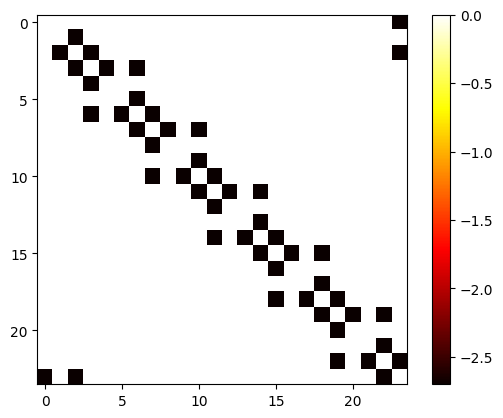

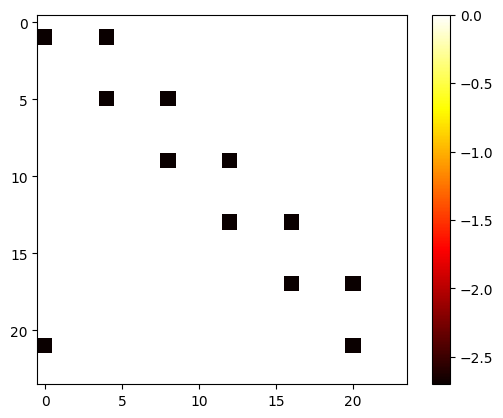

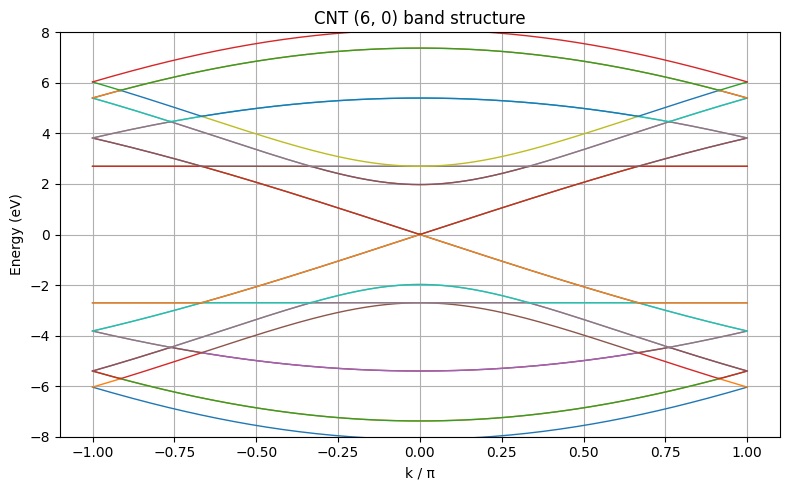

In [187]:
leads = create_nanotube(n=n, m=m, length=ncells, bond=bond, pbc=True, direction="x")
H0_leads, V_leads = build_real_space_lead_hamiltonian(leads, beta=beta, t0=first_neighbor_hopping, neighbor_cutoff=neighbor_cutoff, atol=0.1)
S0_leads = np.eye(H0_leads.shape[0])        # Overlap within unit cell
S1_leads = np.zeros_like(H0_leads)         # Overlap between cells
plt.imshow(H0_leads, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()
plt.imshow(V_leads, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()
plot_band_structure(H0_leads,V_leads,title=f"CNT {(n,m)} band structure")

In [188]:
# Initialize self-energy list for left and right leads
self_energy = [None, None]

# Create LeadSelfEnergy objects for left and right leads
# Uses Sancho Rubio method to compute the surface Green's function
self_energy[0] = LeadSelfEnergy((H0_leads, S0_leads), (V_leads, S1_leads), eta=1e-8,)
self_energy[1] = LeadSelfEnergy(
    (H0_leads, S0_leads), (V_leads, S1_leads), id="right", eta=1e-8,
)


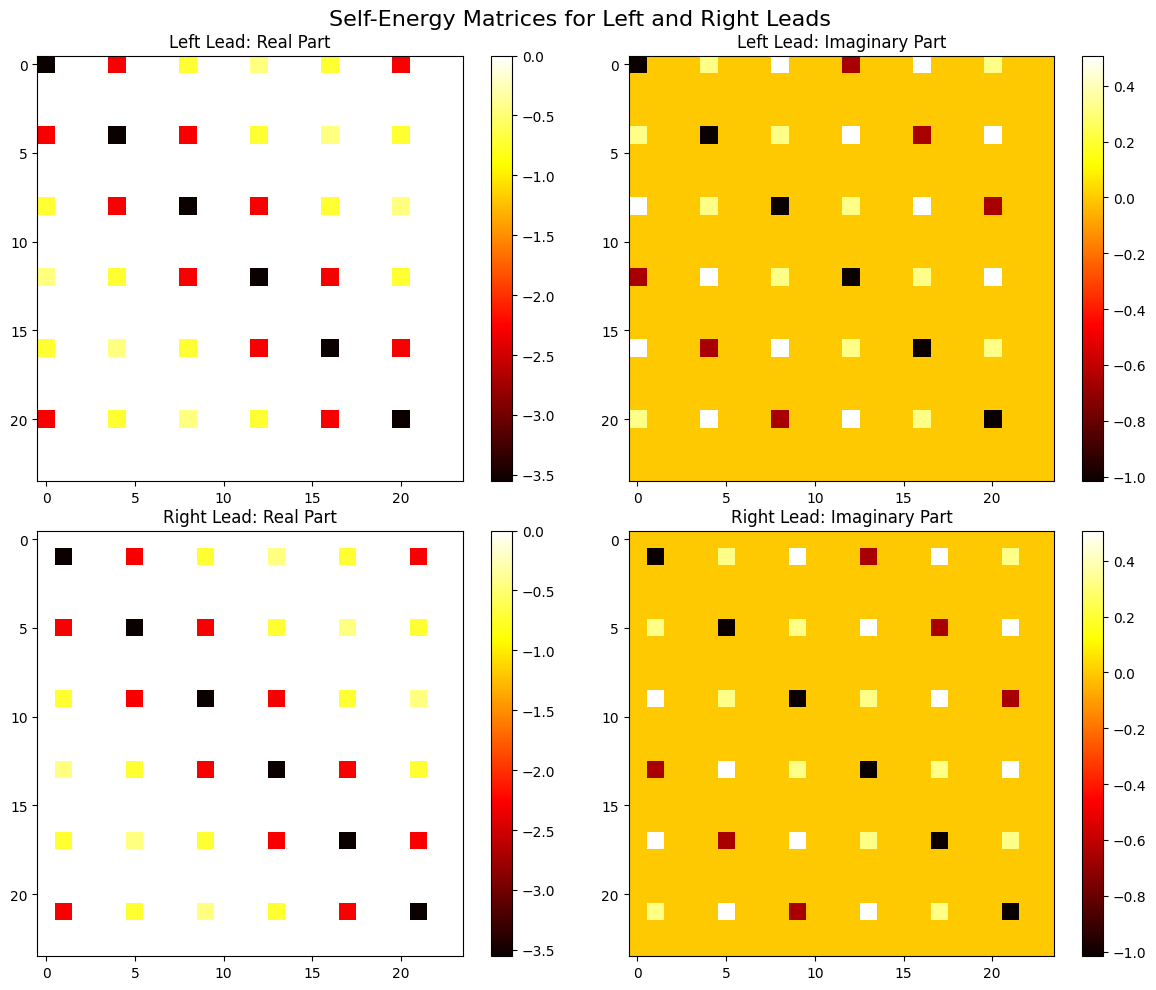

In [189]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Left lead (self_energy[0])
im0 = axs[0, 0].imshow(self_energy[0].retarded(-2.0).real, cmap="hot", interpolation="nearest")
axs[0, 0].set_title("Left Lead: Real Part")
fig.colorbar(im0, ax=axs[0, 0])

im1 = axs[0, 1].imshow(self_energy[0].retarded(-2.0).imag, cmap="hot", interpolation="nearest")
axs[0, 1].set_title("Left Lead: Imaginary Part")
fig.colorbar(im1, ax=axs[0, 1])

# Right lead (self_energy[1])
im2 = axs[1, 0].imshow(self_energy[1].retarded(-2.0).real, cmap="hot", interpolation="nearest")
axs[1, 0].set_title("Right Lead: Real Part")
fig.colorbar(im2, ax=axs[1, 0])

im3 = axs[1, 1].imshow(self_energy[1].retarded(-2.0).imag, cmap="hot", interpolation="nearest")
axs[1, 1].set_title("Right Lead: Imaginary Part")
fig.colorbar(im3, ax=axs[1, 1])

# Improve layout
fig.suptitle("Self-Energy Matrices for Left and Right Leads", fontsize=16)
plt.tight_layout()
plt.show()


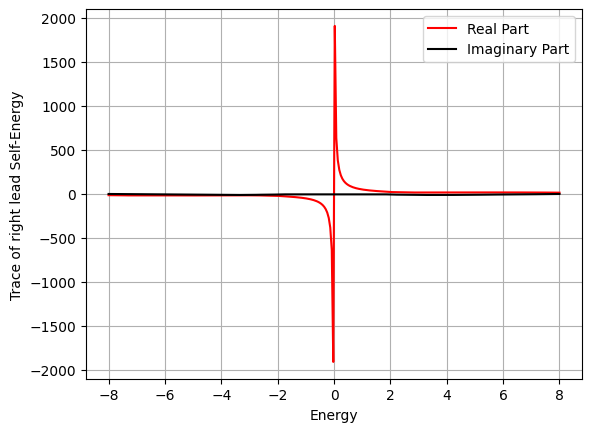

In [190]:
sigma_trace = []
sigmas = []
for E in energies:
    sigma = self_energy[1].retarded(E)
    trace_sigma = np.trace(sigma)
    sigmas.append(sigma)
    sigma_trace.append(trace_sigma)
sigmas = np.array(sigmas)
plt.plot(energies, np.real(sigma_trace), label="Real Part",color="red")
plt.plot(energies, np.imag(sigma_trace), label="Imaginary Part",color="black")
plt.xlabel("Energy")
plt.ylabel("Trace of right lead Self-Energy")
plt.legend()
plt.grid()

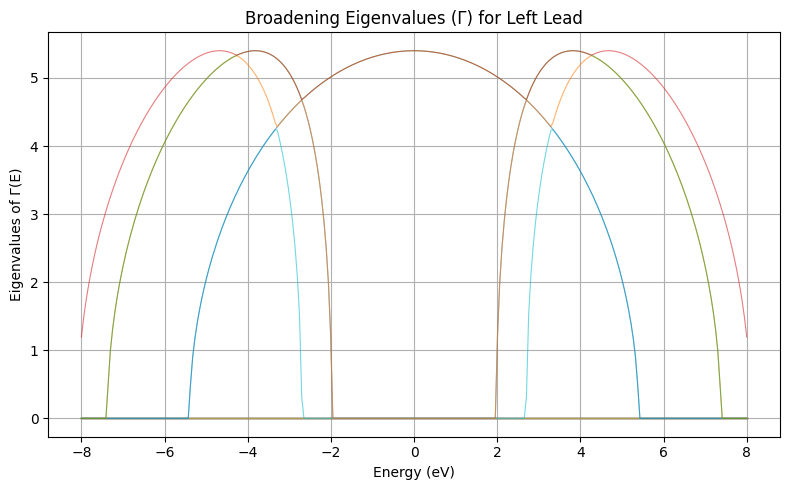

In [191]:
plot_gamma_eigenvalues(self_energy[0], energies, label="Left Lead",log=False)

If we have N atoms in the leads, the leads self energy will be an N X N matrix and therefore, gamma will also be N X N. This means we obtain N eigenvalues of gamma. The number of non-zero eigenvalues at each energy correspond to the number of modes or open channels available in the leads for transport.

In [192]:
threshold = 1e-1
counts = [(np.linalg.eigvalsh(1j * (self_energy[0].retarded(E) -
                                     self_energy[0].retarded(E).T.conj())) > threshold).sum() for E in energies]


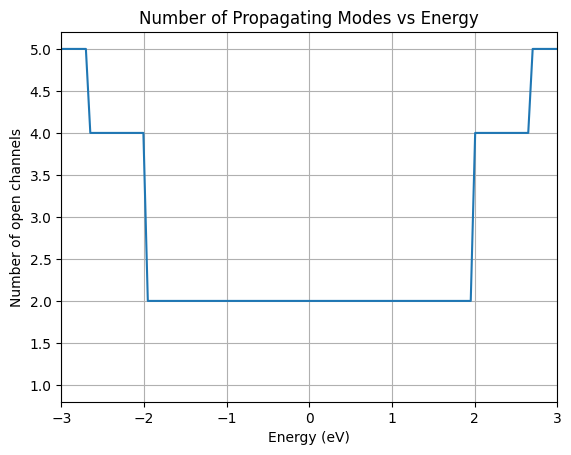

In [193]:
plt.plot(energies, counts)
plt.title("Number of Propagating Modes vs Energy")
plt.xlabel("Energy (eV)")
plt.ylabel("Number of open channels")
plt.xlim(-3, 3)
plt.grid()
plt.show()

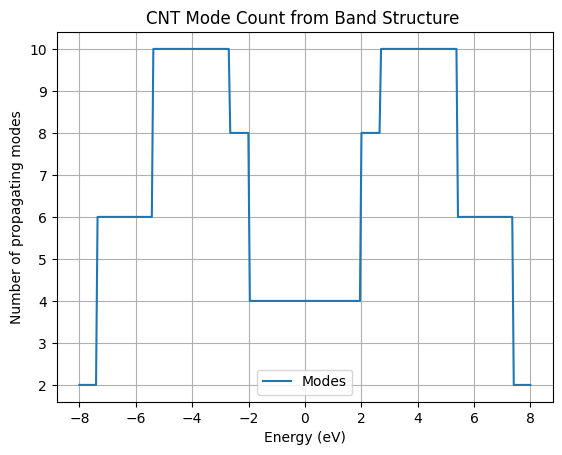

In [194]:
mode_counts = compute_mode_count_from_bandstructure(H0_leads, V_leads, energies)

plt.plot(energies, mode_counts, label="Modes")
plt.xlabel("Energy (eV)")
plt.ylabel("Number of propagating modes")
plt.title("CNT Mode Count from Band Structure ")
plt.grid()
plt.legend()
plt.show()

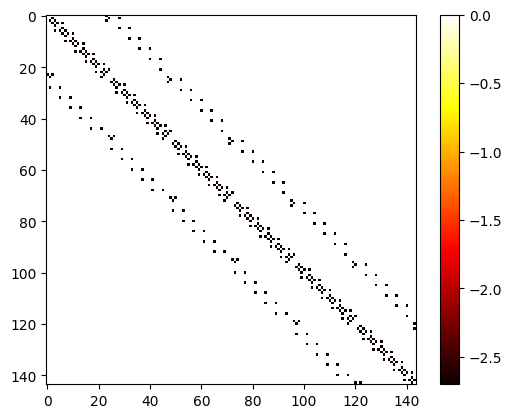

In [195]:
device = build_device_structure(n=6, m=0, N_L=2, N_M=2, N_R=2, direction='x')
pairs = get_nearest_neighbor_pairs(device, neighbor_cutoff=neighbor_cutoff)
H_device= build_real_space_device_hamiltonian(device, pairs, bond=bond, beta=beta, t0=first_neighbor_hopping, atol=0.1)
S_device = np.eye(H_device.shape[0])
plt.imshow(H_device, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

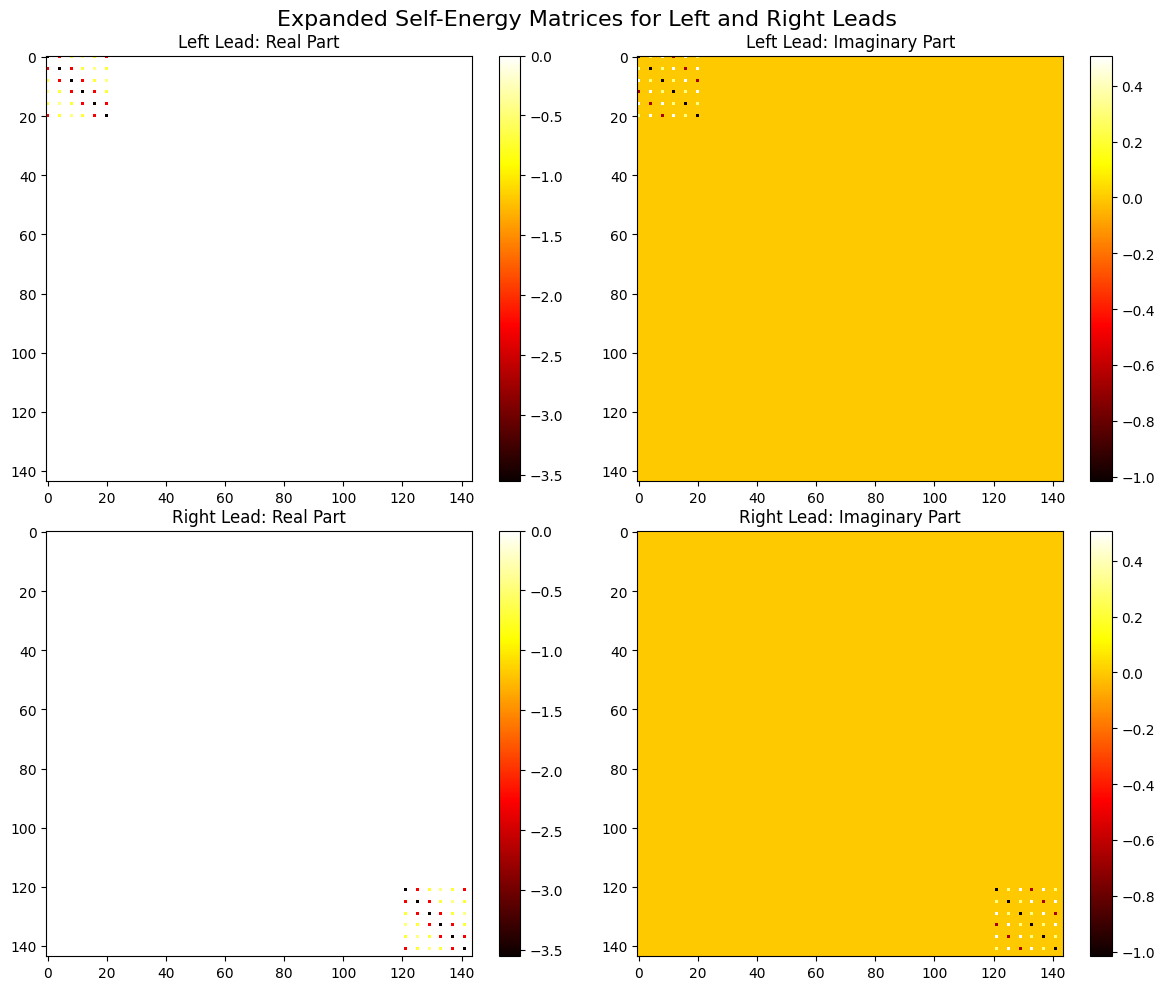

In [196]:
# expand dimension of lead self energy to dimension of scattering region
expand_coupling(self_energy[0], len(H_device[0]))
expand_coupling(self_energy[1], len(H_device[0]), id='right')
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Left lead (self_energy[0])
im0 = axs[0, 0].imshow(self_energy[0].retarded(-2.0).real, cmap="hot", interpolation="nearest")
axs[0, 0].set_title("Left Lead: Real Part")
fig.colorbar(im0, ax=axs[0, 0])

im1 = axs[0, 1].imshow(self_energy[0].retarded(-2.0).imag, cmap="hot", interpolation="nearest")
axs[0, 1].set_title("Left Lead: Imaginary Part")
fig.colorbar(im1, ax=axs[0, 1])

# Right lead (self_energy[1])
im2 = axs[1, 0].imshow(self_energy[1].retarded(-2.0).real, cmap="hot", interpolation="nearest")
axs[1, 0].set_title("Right Lead: Real Part")
fig.colorbar(im2, ax=axs[1, 0])

im3 = axs[1, 1].imshow(self_energy[1].retarded(-2.0).imag, cmap="hot", interpolation="nearest")
axs[1, 1].set_title("Right Lead: Imaginary Part")
fig.colorbar(im3, ax=axs[1, 1])

# Improve layout
fig.suptitle("Expanded Self-Energy Matrices for Left and Right Leads", fontsize=16)
plt.tight_layout()
plt.show()


In [197]:
eta = 1e-5

# slice(None) means that we've already expanded the leads to the scattering region
gf = GreenFunction(H_device, S_device, selfenergies=[(slice(None),self_energy[0]),(slice(None),self_energy[1])], eta=eta)


In [198]:
energies = np.linspace(-3, 3, 100)
gd = GridDesc(energies, 1)
T = np.empty(gd.energies.size)

for e, energy in enumerate(gd.energies):
    T[e] = gf.get_transmission(energy, ferretti=False)

T = gd.gather_energies(T)

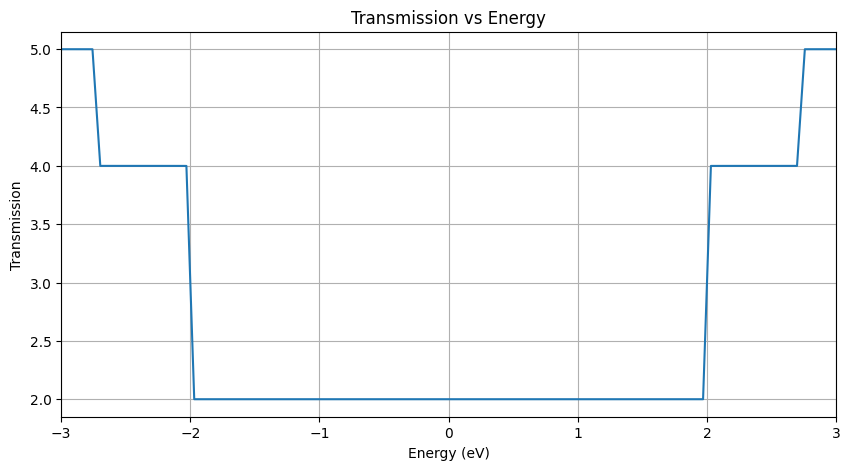

In [199]:
plt.figure(figsize=(10, 5))
plt.plot(energies, T)
plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy")
plt.xlim(-3, 3)
# plt.ylim(0, 1)
plt.grid()
plt.show()


### Apply strain


In [200]:
apply_strain_to_region(device, N_L=2, N_M=2, N_R=2, strain=0.5)
view(device,viewer="x3d", show_unit_cell=True, show_bonds=True, bond_radius=0.1)

In [205]:
beta = 5
H_strained_device = build_real_space_device_hamiltonian(device, pairs, bond=bond, beta=beta, t0=first_neighbor_hopping)

gf = GreenFunction(H_strained_device, S_device, selfenergies=[(slice(None),self_energy[0]),(slice(None),self_energy[1])], eta=eta)

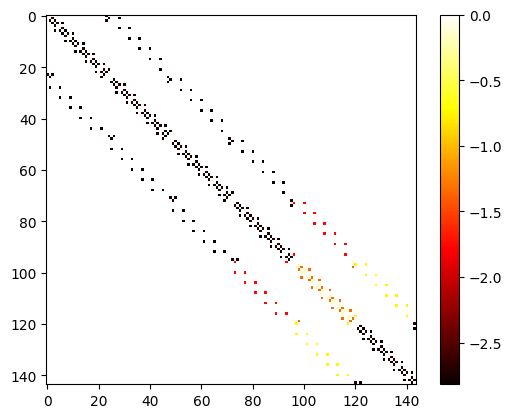

In [206]:
plt.imshow(H_strained_device, cmap='hot', interpolation='nearest')
plt.colorbar()

In [207]:
T = np.empty(gd.energies.size)

for e, energy in enumerate(gd.energies):
    T[e] = gf.get_transmission(energy, ferretti=False)

T = gd.gather_energies(T)

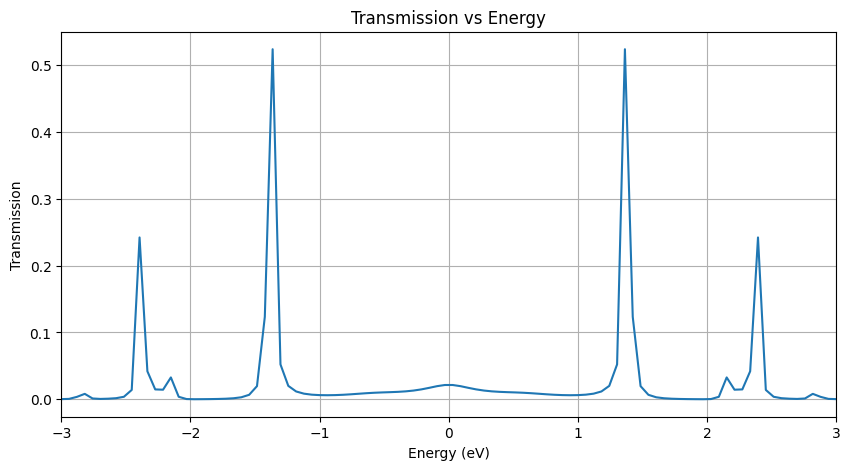

In [208]:
plt.figure(figsize=(10, 5))
plt.plot(energies, T)
plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy")
plt.xlim(-3, 3)
# plt.ylim(0, 1)
plt.grid()
plt.show()
